# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:03<00:00, 15.4KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

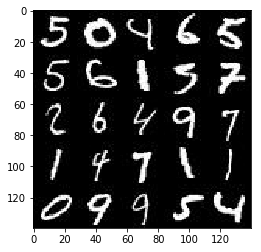

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

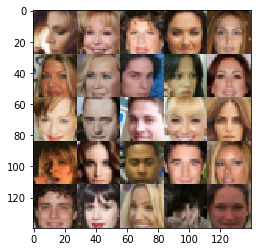

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    def activate(t, alpha):
        return tf.maximum(t * alpha, t)
    
    alpha = 0.2
    n_layer = 3
    filters = [64, 126, 256]
    batch_normalization = [False, True, True]
    
    assert len(filters) == n_layer
    assert len(batch_normalization) == n_layer
    
    layer = images
    
    with tf.variable_scope('discriminator',reuse=reuse):
        for i in range(n_layer):
            layer = tf.layers.conv2d(inputs=layer, filters=filters[i], kernel_size=5, strides=2, padding='same')
            
            if batch_normalization[i]:
                layer = tf.layers.batch_normalization(layer, training=True)
            
            layer = activate(layer, alpha)
        
        flattened = tf.reshape(layer, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    def activate(t, alpha):
        return tf.maximum(t * alpha, t)
    
    alpha = 0.1
    
    n_layer = 3
    filters = [256, 128, out_channel_dim]
    strides = [1, 2, 2]
    paddings = ['valid', 'same', 'same']
    activated = [True, True, False]
    kernel_size = [4, 5, 5]
    
    assert len(filters) == n_layer
    assert len(paddings) == n_layer
    assert len(strides) == n_layer
    assert len(activated) == n_layer
    assert len(kernel_size) == n_layer
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer = tf.layers.dense(z, 4 * 4 * 512)
        layer = tf.reshape(layer, (-1, 4, 4, 512))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = activate(layer, alpha)
        
        for i in range(n_layer):
            layer = tf.layers.conv2d_transpose(layer, filters[i], kernel_size[i], strides=strides[i], padding=paddings[i])
            
            if activated[i]:
                layer = tf.layers.batch_normalization(layer, training=is_train)
                layer = activate(layer, alpha)
        
        output = tf.tanh(layer)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    gen = generator(z=input_z, out_channel_dim=out_channel_dim, is_train=True)
    dis_real, logits_real = discriminator(images=input_real, reuse=False)
    dis_fake, logits_fake = discriminator(images=gen, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_real,
            labels=tf.ones_like(dis_real) * 0.9
        )
    )
    
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake,
            labels=tf.zeros_like(dis_fake)
        )
    )
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake,
            labels=tf.ones_like(dis_fake)
        )
    )
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    tv = tf.trainable_variables()
    
    dis_vars = [v for v in tv if v.name.startswith('discriminator')]
    gen_vars = [v for v in tv if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return dis_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    losses = []
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z , learning_rate_pl = model_inputs(
        image_width,
        image_height,
        image_channels,
        z_dim
    )
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate_pl, beta1)
    
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1 ,size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_pl: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_pl: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_pl: learning_rate})
                
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, learning_rate_pl: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z, learning_rate_pl: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess,n_images,input_z,image_channels,data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9729... Generator Loss: 0.0874
Epoch 1/2... Discriminator Loss: 3.4243... Generator Loss: 0.0513
Epoch 1/2... Discriminator Loss: 3.0247... Generator Loss: 0.0870
Epoch 1/2... Discriminator Loss: 2.6098... Generator Loss: 0.1421
Epoch 1/2... Discriminator Loss: 1.8762... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.9456... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 2.4539... Generator Loss: 0.2098
Epoch 1/2... Discriminator Loss: 1.9861... Generator Loss: 0.3300
Epoch 1/2... Discriminator Loss: 1.6019... Generator Loss: 0.6223
Epoch 1/2... Discriminator Loss: 1.9170... Generator Loss: 0.8847


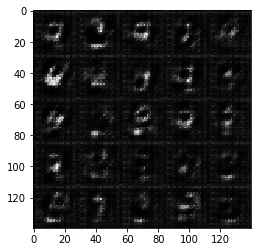

Epoch 1/2... Discriminator Loss: 1.6361... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.7245... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 1.5758... Generator Loss: 0.4564
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 1.6801... Generator Loss: 0.3771
Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.4659
Epoch 1/2... Discriminator Loss: 1.7069... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.6748... Generator Loss: 0.3693


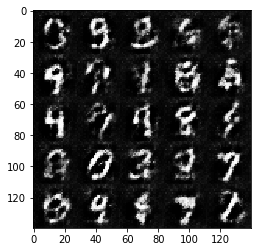

Epoch 1/2... Discriminator Loss: 1.5623... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.5985... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.5883... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 1.0483
Epoch 1/2... Discriminator Loss: 1.5001... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.9561


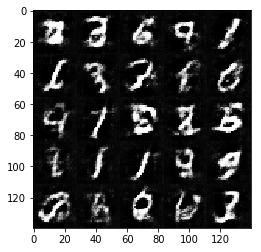

Epoch 1/2... Discriminator Loss: 1.4383... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.9010
Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 1.2271


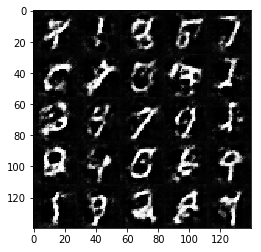

Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.8976
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 1.4653... Generator Loss: 0.9248
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.7678
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.9362


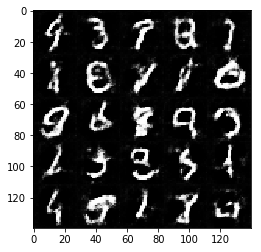

Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 1.5017... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.8856
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.8691


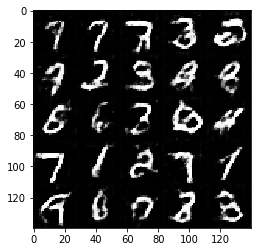

Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.8858
Epoch 1/2... Discriminator Loss: 1.5306... Generator Loss: 1.1231
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 1.0058
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.7735... Generator Loss: 0.3132


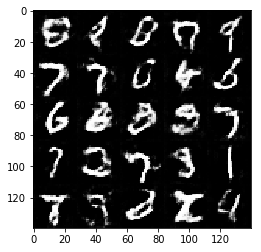

Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 1.5551... Generator Loss: 0.4480
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.4037
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.5118
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.8495


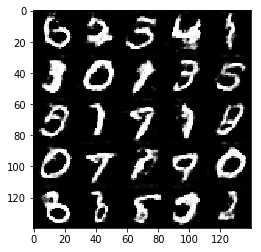

Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.7247... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.6723... Generator Loss: 1.2719
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.7941


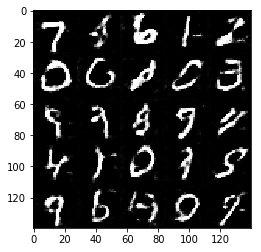

Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.7222... Generator Loss: 0.3209
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 1.4834... Generator Loss: 0.5236
Epoch 2/2... Discriminator Loss: 1.6296... Generator Loss: 0.3714


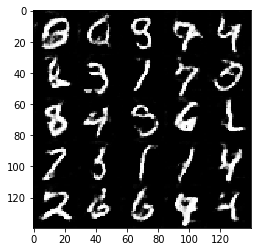

Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.5245... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.4535
Epoch 2/2... Discriminator Loss: 1.5535... Generator Loss: 0.4311
Epoch 2/2... Discriminator Loss: 1.5413... Generator Loss: 0.4210
Epoch 2/2... Discriminator Loss: 1.5004... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 2.0417... Generator Loss: 1.3507
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.6791


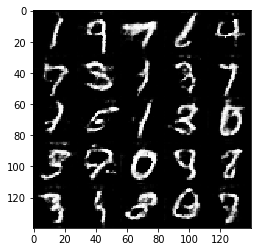

Epoch 2/2... Discriminator Loss: 1.6291... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 1.4846... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.5493
Epoch 2/2... Discriminator Loss: 1.6345... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 1.6660... Generator Loss: 0.3671
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 1.0027
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.5132... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.6064


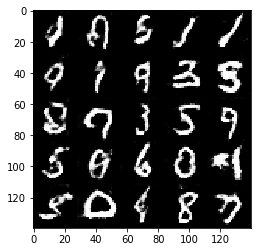

Epoch 2/2... Discriminator Loss: 1.8667... Generator Loss: 1.5158
Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.4670... Generator Loss: 0.5804
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.8781... Generator Loss: 1.9744
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.5677... Generator Loss: 0.4228
Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.4248


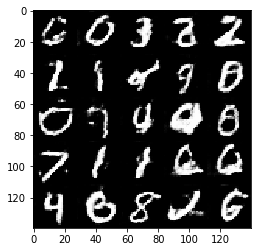

Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.8654... Generator Loss: 1.5498
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.9269... Generator Loss: 0.2481
Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.5849
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 1.1169


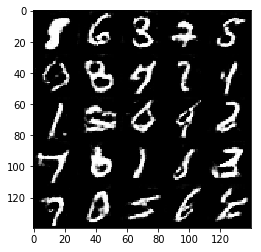

Epoch 2/2... Discriminator Loss: 1.4064... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.3578... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 1.0795
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.9706
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.7154


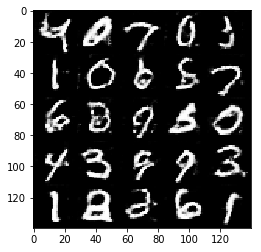

Epoch 2/2... Discriminator Loss: 1.6727... Generator Loss: 0.3471
Epoch 2/2... Discriminator Loss: 1.4120... Generator Loss: 0.5429
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 1.5157... Generator Loss: 0.4350
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.8346... Generator Loss: 0.2783
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.7996


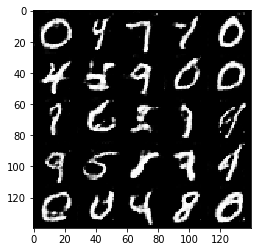

Epoch 2/2... Discriminator Loss: 1.6476... Generator Loss: 0.3659
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.5481... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 1.4773... Generator Loss: 0.4872
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 1.0172
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.0266
Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 0.9986
Epoch 2/2... Discriminator Loss: 1.7626... Generator Loss: 0.3096
Epoch 2/2... Discriminator Loss: 1.8031... Generator Loss: 0.2925
Epoch 2/2... Discriminator Loss: 1.5433... Generator Loss: 0.4552


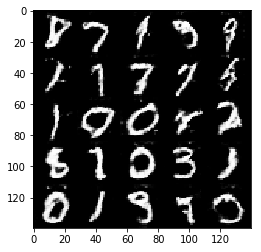

Epoch 2/2... Discriminator Loss: 1.6882... Generator Loss: 0.3551
Epoch 2/2... Discriminator Loss: 1.5728... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 1.5835... Generator Loss: 0.3959
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.5006
Epoch 2/2... Discriminator Loss: 1.6411... Generator Loss: 1.6679
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 1.6847
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.7596
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 1.5279... Generator Loss: 0.4328


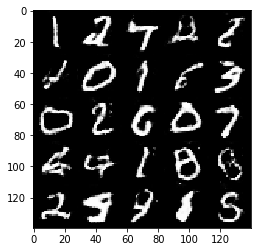

Epoch 2/2... Discriminator Loss: 1.8267... Generator Loss: 0.2814
Epoch 2/2... Discriminator Loss: 1.7381... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.5405... Generator Loss: 1.1824
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 1.6860... Generator Loss: 0.3405
Epoch 2/2... Discriminator Loss: 1.4421... Generator Loss: 0.4737


In [32]:
batch_size = 64
z_dim = 130
learning_rate = 0.0005
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.3863... Generator Loss: 0.0044
Epoch 1/1... Discriminator Loss: 3.3200... Generator Loss: 0.0793
Epoch 1/1... Discriminator Loss: 2.3982... Generator Loss: 0.2629
Epoch 1/1... Discriminator Loss: 2.4998... Generator Loss: 0.1843
Epoch 1/1... Discriminator Loss: 1.9770... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.9446... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.7457... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.8294


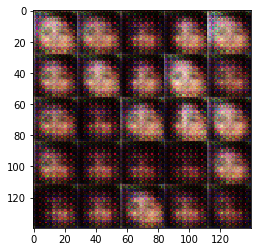

Epoch 1/1... Discriminator Loss: 2.2059... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.9080... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7623


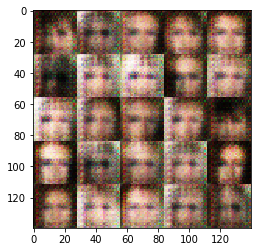

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.7049


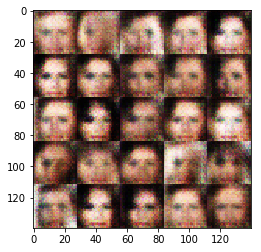

Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6599


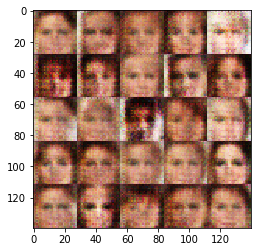

Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.8810


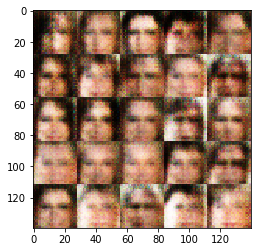

Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7878


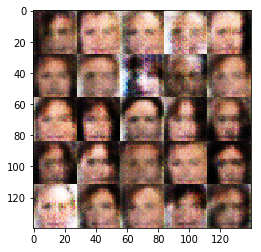

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.8149


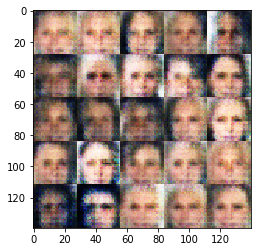

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7582


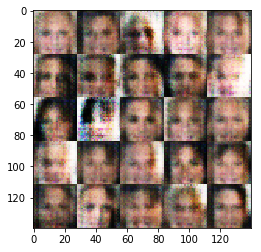

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7058


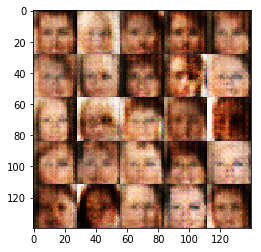

Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7445


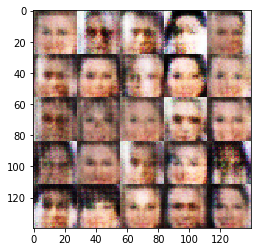

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8342


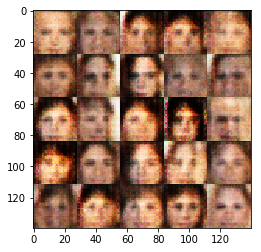

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7807


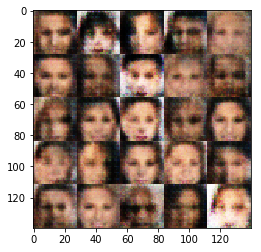

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8559


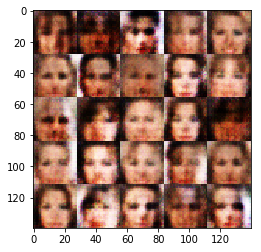

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8039


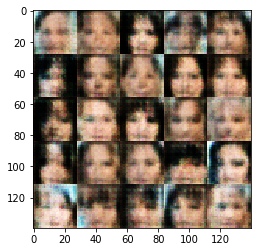

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7687


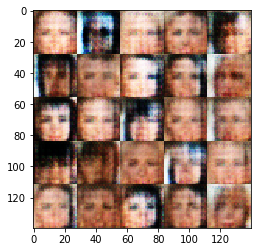

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6938


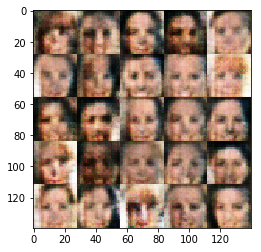

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8021


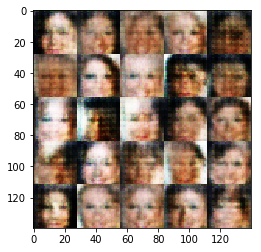

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8425


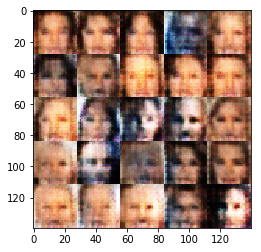

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6808


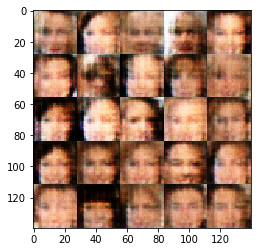

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 1.0334


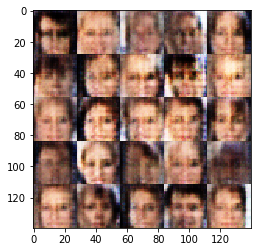

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7545


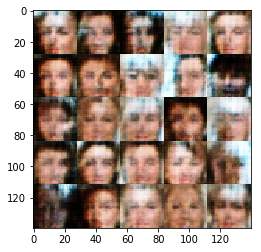

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7598


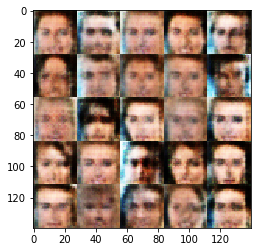

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7797


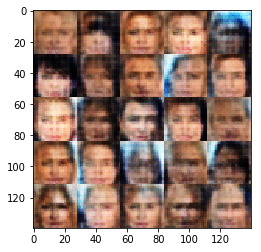

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6930


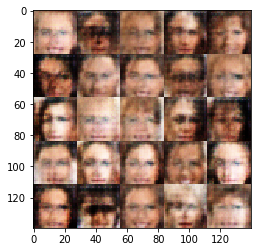

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6815


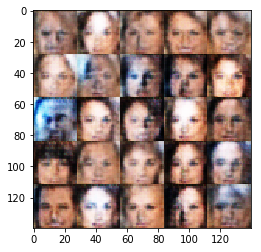

Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8317


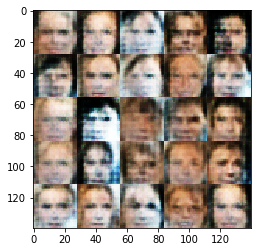

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7407


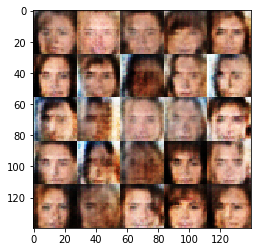

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6370


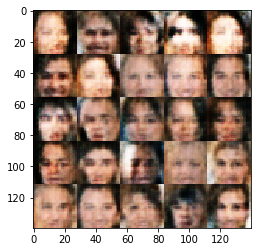

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7445


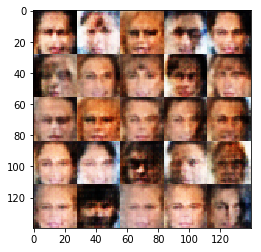

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7145


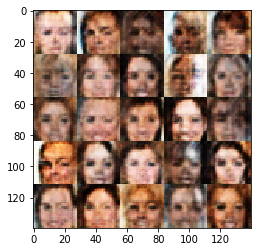

Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6929


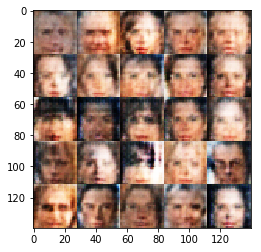

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8625


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.